# Introduction
There was a kaggle style competition at my university to classify news articles using R language. The news articles had 23 labels that had been changed to be C1 to C23 and our goal was to achieve the highest F1 macro score. <br>
Here for simplicity purpose we are just using accuracy as a metric for performance comparision. <br>
So far we have preprocessed the given news articles and corresponding labels and made them ready to perform modelling on them. 
Preprocessing can be seen in this  <a href="https://github.com/VarunM24/data-science-portfolio/blob/master/Python/Machine%20Learning/text-classification/News-classification/pre-processing/News-Preprocessing.ipynb" >notebook </a>.
<br><br>In this notebook we will be performing modelling on the news articles using the following algorithms for comparison. 
#### - Naive bayes
#### - Logistic regression
#### - Linear SVM
#### - Multilayer perceptron
#### - CNN - - with/without ngram collocation and using pretrained wordembedding
#### - CNN + LSTM -  with with/without collocation and using pretrained wordembedding
#### - FastText 
<br>
In various research papers these algorithms have been seen to have performed quite well which is why we chose them for comparison.
The parameters to these algorithms were found out though either grid search or by testing out different configurations. The final configurations have been used here.
<br> Originally this task was completed in R language. The same models have been reproduced here for the sake of improving proficiency in python and learning how to use different deep learning libraries in python for text classification.

======================================================================================================================

#### Importing libraries

In [88]:
# importing libraries
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GlobalAveragePooling1D
from keras.callbacks import  EarlyStopping
import re
from fastText import train_supervised
import urllib.request


### Loading the cleaned data

In [89]:
def read_data_from_url(filepath):
    ''' Reads news article document data from url
    
    Parameters:
    ----------
    filepath : str
        url to get the news article documents from
    
    Returns:
    --------
    temp_data : list
        list of documents that were read from the url given
    
    '''
    fp = urllib.request.urlopen(filepath)
    temp_data = fp.readlines()
    temp_data = [x.decode("latin-1").replace('\n','').replace('\r','') for x in  temp_data]
    fp.close()
    return temp_data

def read_data1(filepath):
    ''' Obtains news article documents from local file path
    
    Parameters:
    ----------
    filepath : str
        local file path to get the news article documents from
    
    Returns:
    --------
    temp_data : list
        list of documents that were read from the filepath given    
    '''
    temp_data = open(filepath,'r')
    temp_data = temp_data.readlines()
    temp_data = [x.replace('\n','') for x in  temp_data]
    return temp_data

def read_label(filepath):
    ''' Obtains news article documents labels from local file path or url
    
    Parameters:
    ----------
    filepath : str
        local file path or url to get the news article documents labels from
    
    Returns:
    --------
    temp_data : list
        list of labels of news documents that were read from the filepath/url given    
    '''
    temp_pd  = pd.read_csv(filepath)
    temp_pd = temp_pd.y.str.replace('C','')
    return list(temp_pd.values)

def read_testing_label(filepath):
    ''' Obtains news article documents test set labels from url
    
    Parameters:
    ----------
    filepath : str
        url to get the news article documents labels of test set 
    
    Returns:
    --------
    temp_data : list
        list of labels of test set news documents that were read from the url given    
    '''
    fp = urllib.request.urlopen(filepath)
    temp_data = fp.readlines()
    x = pd.DataFrame(temp_data)
    str_df = x.stack().str.decode('utf-8').unstack()
    str_df = str_df.loc[:,0].str.extract('.+C(\d+)\r\n')
    fp.close()
    return  str_df



In [90]:
# Files are stored on Dropbox
# Original unprocessed data - https://www.dropbox.com/sh/6hbhx9t5gbadox1/AACbFbyPSf2Gl_20Z6-vo0SIa?dl=1
# Processed data - https://www.dropbox.com/sh/b21j3vrivynm3qq/AACQO-5IhVySCsEUfW5iGm7ca?dl=1

train_data_ngram = read_data_from_url('https://www.dropbox.com/s/345f53i28jzgbwf/train_data1.txt?dl=1')
train_data_no_ngram = read_data_from_url('https://www.dropbox.com/s/dg60mnmph5peo3j/train_data_no_ngram.txt?dl=1')
val_data_ngram = read_data_from_url('https://www.dropbox.com/s/jhwoc3itepiru5n/validation_data1.txt?dl=1')
val_data_no_ngram = read_data_from_url('https://www.dropbox.com/s/2gmv1u90gs1bcfe/validation_data_no_ngram.txt?dl=1')
complete_data_ngram = read_data_from_url('https://www.dropbox.com/s/nwtja7kqt8zxeo0/complete_data1.txt?dl=1')
complete_data_no_ngram = read_data_from_url ('https://www.dropbox.com/s/n8weciidr2p8w89/complete_data_no_ngram.txt?dl=1')
train_label_ngram = read_label('https://www.dropbox.com/s/s6awj7z6u5twwzr/train_labels1.csv?dl=1')
train_label_no_ngram = read_label('https://www.dropbox.com/s/zn6q7kjns2o8lde/train_labels_no_ngram.csv?dl=1')
val_label_ngram = read_label('https://www.dropbox.com/s/yazczj4wylnwowt/validation_labels1.csv?dl=1')
val_label_no_ngram  = read_label('https://www.dropbox.com/s/13s4sm2u4a8ze7n/validation_labels_no_ngram.csv?dl=1')
test_labels = read_testing_label('https://www.dropbox.com/s/tufczh9achf84zr/testing_labels.txt?dl=1')

test_data_ngram = read_data_from_url('https://www.dropbox.com/s/xusb0moohur7y8c/test_data1.txt?dl=1')
test_data_no_ngram = read_data_from_url('https://www.dropbox.com/s/mywzv8o8v57nem9/test_data_no_ngram.txt?dl=1')
    
complete_labels_ngram =  train_label_ngram + val_label_ngram
complete_labels_no_ngram = train_label_no_ngram + val_label_no_ngram

C:\Users\VM\AppData\Roaming\Python\Python35\site-packages\ipykernel\__main__.py:73: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [91]:
# Creating dictionary to store different model performances
df_performances = {}

## Using TF IDF
#### First we will create models using TF IDF form of the data and evaluate their performance on validation data


#### Creating tf-idf matrix for ngram data

In [92]:
# learning the tfidf vectorizer to learn vocabulary and the id values of each word from training data
tfidf_vectorizer = TfidfVectorizer(input = 'content', analyzer = 'word')
tfidf_train_data_ngram = tfidf_vectorizer.fit_transform(complete_data_ngram)
# transforming test data into idf vector
tfidf_test_data_ngram = tfidf_vectorizer.transform(test_data_ngram) 

#### Creating tf-idf matrix for data without ngrams

In [93]:
# learning the tfidf vectorizer to learn vocabulary and the id values of each word from training data
tfidf_vectorizer = TfidfVectorizer(input = 'content', analyzer = 'word')
tfidf_train_data_no_ngram = tfidf_vectorizer.fit_transform(complete_data_no_ngram)
# transforming test data into idf vector
tfidf_test_data_no_ngram = tfidf_vectorizer.transform(test_data_no_ngram) 

## Naive Bayes classifier
=================================
### 5 fold Crossvalidation performance

In [94]:
# Creating a stratified shuffled split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=321)

In [95]:
clf_MNB = MultinomialNB(alpha = 0.1)
crossval_arr = cross_val_score(clf_MNB, tfidf_train_data_ngram, complete_labels_ngram, cv=sss)
avg_nb = (sum(crossval_arr)/len(crossval_arr))*100

In [144]:
print ('NB 5 fold crossvalidation avg accuracy = {0:.2f} % '.format(avg_nb))

NB 5 fold crossvalidation avg accuracy = 75.28 % 


### Performance on test dataset

In [97]:
clf_MNB = clf_MNB.fit(tfidf_train_data_ngram, complete_labels_ngram)
predicted_nb = clf_MNB.predict(tfidf_test_data_ngram)
nb_accu = accuracy_score (test_labels,predicted_nb) *100

In [145]:
print ('NB test accuracy = {0:.2f} % '.format(nb_accu))

NB test accuracy = 73.99 % 


In [99]:
# Adding to performance dictionary
df_performances['NB_ngram'] = nb_accu

## SVM classifier
=======================
### 5 fold Crossvalidation performance

In [100]:
clf_svm= OneVsOneClassifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-4, max_iter=50, random_state=42))

In [146]:
crossval_arr_svm = cross_val_score(clf_svm, tfidf_train_data_ngram, complete_labels_ngram, cv=sss)
avg_svm = (sum(crossval_arr_svm)/len(crossval_arr_svm))*100
print ('SVM 5 fold crossvalidation avg accuracy =  {0:.2f} % '.format(avg_svm))

SVM 5 fold crossvalidation avg accuracy =  77.95 % 


### Performance on test dataset

In [102]:
clf_svm = clf_svm.fit(tfidf_train_data_ngram, complete_labels_ngram)
predicted_svm = clf_svm.predict(tfidf_test_data_ngram)
svm_accu = accuracy_score (test_labels,predicted_svm)*100
print ('SVM test accuracy = {0:.2f} % '.format(svm_accu))

SVM test accuracy = 7.7e+01 % 


In [147]:
print ('SVM test accuracy = {0:.2f} % '.format(svm_accu))

SVM test accuracy = 76.85 % 


In [103]:
# Adding to performance dictionary
df_performances['SVM_ngram'] = svm_accu

In [104]:
tfidf_train_data_ngram.shape

(106443, 45367)

## MLP Classifier
========================
### 2 Crossvalidation performance

In [105]:
# Creating a stratified shuffled split
sss_mlp = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=321)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2)
crossval_arr_mlp = cross_val_score(mlp_clf, tfidf_train_data_ngram, complete_labels_ngram, cv=sss_mlp)
avg_mlp = (sum(crossval_arr_mlp)/len(crossval_arr_mlp))*100
print ('100 neuron MLP 2 fold crossvalidation avg accuracy =   {0:.2f} % '.format(avg_mlp))

C:\Users\VM\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\VM\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


100 neuron MLP 2 fold crossvalidation avg accuracy =   7.8e+01 % 


In [148]:
print ('100 neuron MLP 2 fold crossvalidation avg accuracy =   {0:.2f} % '.format(avg_mlp))

100 neuron MLP 2 fold crossvalidation avg accuracy =   78.16 % 


### Performance on test dataset

In [106]:
mlp = mlp_clf.fit(tfidf_train_data_ngram, complete_labels_ngram)
predicted_mlp = mlp.predict(tfidf_test_data_ngram)
mlp_accu = accuracy_score (test_labels,predicted_mlp)*100
print ('100 neuron MLP test accuracy =   {0:.2f} % '.format(mlp_accu))

100 neuron MLP test accuracy =   7.7e+01 % 


In [149]:
print ('100 neuron MLP test accuracy =   {0:.2f} % '.format(mlp_accu))

100 neuron MLP test accuracy =   77.15 % 


In [107]:
# Adding to performance dictionary
df_performances['MLP_100N_ngram'] = mlp_accu

### Logistic Regression
==========================

In [108]:
lr_clf = LogisticRegression()
crossval_arr = cross_val_score(lr_clf, tfidf_train_data_ngram, complete_labels_ngram, cv=sss)
avg_lr = (sum(crossval_arr)/len(crossval_arr))*100
print ('LR 5 fold crossvalidation avg accuracy =   {0:.2f} % '.format(avg_lr))


LR 5 fold crossvalidation avg accuracy =   7.8e+01 % 


In [150]:
print ('LR 5 fold crossvalidation avg accuracy =   {0:.2f} % '.format(avg_lr))


LR 5 fold crossvalidation avg accuracy =   78.03 % 


In [109]:
lr_clf = lr_clf.fit(tfidf_train_data_ngram, complete_labels_ngram)
predicted_lr = lr_clf.predict(tfidf_test_data_ngram)
lr_accu = accuracy_score (test_labels,predicted_lr) *100
print ('LR test accuracy =   {0:.2} % '.format(lr_accu))

LR test accuracy =   7.7e+01 % 


In [ ]:
print ('LR test accuracy =   {0:.2f} % '.format(lr_accu))

In [110]:
# Adding to performance dictionary
df_performances['LR_ngram'] = lr_accu

## Using pretrained GloVe word embedding
 GloVe is a type of model which after getting trained can be used to create word embedding i.e. words representation in a vector space which can be used as an alternate representation for words and used as input in deep learning models.  We will use pretrained GloVe model which has been trained on news as well as wikipedia which is a corpus similar to our own. Since these vector representation can retain some sort of semantic information, using it may yield better performance.<br><br>
 For deep learning techniques, we intend to use transfer learning by using pretrained word embedding in our model and to let the model fine tune the weights and learn from our corpus as well to save time and improve performance. And finally these word embeddings will be used as input features to various models. <br><br>
 The pretrained wordembedding file name is glove.6B.100d and can be downloaded from :
https://nlp.stanford.edu/projects/glove/

#### Loading Glove word embedding in dictionary

In [111]:
def loadGlove(Glove_filepath):
    ''' Loads glove pretrained word embeddings from local path
    
    Parameters:
    ----------
    Glove_filepath : str
        local path to glove pretrained word embedding
        
    Returns:
    -------
    embeddings_index: dict
        contains words and their corresponding vector values
    '''
    embeddings_index = {}
    f = open(Glove_filepath, encoding="utf8")
    for line in f:
        values = line.split(' ')
        word = values[0] ## The first entry is the word
        coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
        embeddings_index[word] = coefs
    f.close()
    print('GloVe data loaded')
    return embeddings_index

In [112]:
def loadGlove_from_url(Glove_filepath):
    ''' Loads glove pretrained word embeddings from url
    
    Parameters:
    ----------
    Glove_filepath : str
        local path to glove pretrained word embedding
        
    Returns:
    -------
    embeddings_index: dict
        contains words and their corresponding vector values
    '''
    
    fp = urllib.request.urlopen(Glove_filepath)
#     temp_data = fp.readlines()
#     temp_data = [x.decode("latin-1").replace('\n','').replace('\r','') for x in  temp_data]
    
    embeddings_index = {}
    for line in fp.readlines():
        values = line.decode('utf-8').split(' ')
        word = values[0] ## The first entry is the word
        coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
        embeddings_index[word] = coefs
    fp.close()
    print('GloVe data loaded')
    return embeddings_index

In [113]:
# glove_dict = loadGlove('glove.6B.100d.txt')
# File is 300mb ... download from url may take some time

# glove_dict = loadGlove_from_url('https://www.dropbox.com/s/f25667uh1yzjsxa/glove.6B.50d.txt?dl=1')
glove_dict = loadGlove_from_url('https://www.dropbox.com/s/dxhnb2o27ijegks/glove.6B.100d.txt?dl=1')

GloVe data loaded


## CNN
### We will first be using data without ngrams for CNN model.

#### Preparing the data for CNN

In [114]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
# Getting word embedding 
MAX_SEQUENCE_LENGTH = 130

# Using tokenizer to learn from complete training dataset (validation  + training )
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(complete_data_no_ngram)

# Converting documents to sequence of tokens
complete_train_no_ngram = tokenizer1.texts_to_sequences(complete_data_no_ngram)
complete_test_no_ngram = tokenizer1.texts_to_sequences(test_data_no_ngram)

word_index_no_ngram = tokenizer1.word_index
vocab_size = len(word_index_no_ngram)
max_words = vocab_size


print('Found %s unique words.' % len(word_index_no_ngram))

#padding the sequences incase sequences are shorter than max sequence length
complete_train_no_ngram_padded = pad_sequences(complete_train_no_ngram, maxlen=MAX_SEQUENCE_LENGTH)
complete_test_no_ngram_padded = pad_sequences(complete_test_no_ngram, maxlen=MAX_SEQUENCE_LENGTH)

# converting labels to int and then reducing their value by 1 as the first class will be 0 not 1 (required by keras)
complete_labels_no_ngram = np.array(list(map(int, complete_labels_no_ngram)))
complete_labels_no_ngram = complete_labels_no_ngram - 1

test_labels = np.array(list(map(int, test_labels)))
test_labels = test_labels - 1




Found 116063 unique words.


#### Preparing the embedding matrix for embedding layer  in CNN using pretrained glove word embedding

In [115]:
from keras.layers import Embedding
from keras.initializers import Constant


# Preparing embedding matrix 
EMBEDDING_DIM = glove_dict.get('a').shape[0]
num_words = max_words + 1
embedding_matrix_no_ngram = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index_no_ngram.items():
    if i>max_words:
        continue
    embedding_vector = glove_dict.get(word)
    if(embedding_vector is not None):
        embedding_matrix_no_ngram[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_no_ngram),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) # We set trainable to True because it gives better performance by optimizing the weights more



#### What does an embedding matrix look like?

In [116]:
import matplotlib.pyplot as plt
print(embedding_matrix_no_ngram.shape)
plt.plot(embedding_matrix_no_ngram[16])
plt.show()

(116064, 100)


<Figure size 640x480 with 1 Axes>

#### Creating  the CNN model

In [117]:

model = Sequential()
model.add(embedding_layer)
model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model.add(Dense(64, activation='relu'))
model.add(Dense(23, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [118]:
len(complete_train_no_ngram_padded)

106443

#### Training the CNN model on validation + training dataset

In [119]:
earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
lr_reduce_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)        
model.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, validation_split=0.05, epochs = 7, callbacks = [earlystopping_callback,lr_reduce_callback])

Train on 101120 samples, validate on 5323 samples
Epoch 1/7
101120/101120 [==============================] - 79s 782us/step - loss: 1.2012 - acc: 0.6744 - val_loss: 0.8751 - val_acc: 0.7509
Epoch 2/7
101120/101120 [==============================] - 73s 724us/step - loss: 0.7631 - acc: 0.7726 - val_loss: 0.7832 - val_acc: 0.7665
Epoch 3/7
101120/101120 [==============================] - 74s 734us/step - loss: 0.6279 - acc: 0.8068 - val_loss: 0.7438 - val_acc: 0.7759
Epoch 4/7
101120/101120 [==============================] - 81s 799us/step - loss: 0.5247 - acc: 0.8366 - val_loss: 0.7416 - val_acc: 0.7794
Epoch 5/7
101120/101120 [==============================] - 72s 713us/step - loss: 0.4340 - acc: 0.8631 - val_loss: 0.7642 - val_acc: 0.7785
Epoch 6/7
101120/101120 [==============================] - 72s 710us/step - loss: 0.3528 - acc: 0.8889 - val_loss: 0.7950 - val_acc: 0.7785


#### CNN trained on data without ngram accuracy

In [120]:
no_ngram_cnn_pred7 = model.predict(complete_test_no_ngram_padded)
no_ngram_cnn_pred7 = list(map(np.argmax, no_ngram_cnn_pred7))
no_ngram_cnn_accu7 = accuracy_score (test_labels,no_ngram_cnn_pred7)
no_ngram_cnn_accu7

0.7622322435174747

In [137]:
print ('CNN trained on data with validaiton data without ngram accuracy - test accuracy =   {0:.2f} % '.format(no_ngram_cnn_accu7 *100))

CNN trained on data with validaiton data without ngram accuracy - test accuracy =   76.22 % 


#### Now training on complete data to find accuracy on test data

In [122]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(23, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
#lr_reduce_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)        
model2.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, epochs = 3)

Epoch 1/3
106443/106443 [==============================] - 76s 712us/step - loss: 0.8538 - acc: 0.7782
Epoch 2/3
106443/106443 [==============================] - 76s 711us/step - loss: 0.5192 - acc: 0.8458
Epoch 3/3
106443/106443 [==============================] - 77s 728us/step - loss: 0.4188 - acc: 0.8725


In [123]:
no_ngram_cnn_pred = model2.predict(complete_test_no_ngram_padded)
no_ngram_cnn_pred1 = list(map(np.argmax, no_ngram_cnn_pred))
no_ngram_cnn_accu = accuracy_score (test_labels,no_ngram_cnn_pred1)
no_ngram_cnn_accu

0.7499060503570086

In [138]:
print ('CNN trained on complete data without validaiton data without ngram accuracy - test accuracy =   {0:.2f} % '.format(no_ngram_cnn_accu *100))

CNN trained on complete data without validaiton data without ngram accuracy - test accuracy =   74.99 % 


### Now training CNN using data with ngram

#### Preparing data and embedding matrix

In [125]:
#complete_data_ngram
#complete_labels_ngram


# Getting word embedding 
MAX_SEQUENCE_LENGTH = 130

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(complete_data_ngram)

complete_train_ngram = tokenizer2.texts_to_sequences(complete_data_ngram)
complete_test_ngram = tokenizer2.texts_to_sequences(test_data_ngram)

word_index_ngram = tokenizer2.word_index
vocab_size = len(word_index_ngram)
max_words = vocab_size


print('Found %s unique words.' % len(word_index_ngram))

#padding the sequences
complete_train_ngram_padded = pad_sequences(complete_train_ngram, maxlen=MAX_SEQUENCE_LENGTH)
complete_test_ngram_padded = pad_sequences(complete_test_ngram, maxlen=MAX_SEQUENCE_LENGTH)
complete_labels_ngram = np.array(list(map(int, complete_labels_ngram)))
complete_labels_ngram = complete_labels_ngram - 1

#test_labels = np.array(list(map(int, test_labels)))
#test_labels = test_labels - 1

# Preparing embedding matrix 
EMBEDDING_DIM = glove_dict.get('a').shape[0]
num_words = max_words + 1
embedding_matrix_ngram = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index_ngram.items():
    if i>max_words:
        continue
    embedding_vector = glove_dict.get(word)
    if(embedding_vector is not None):
        embedding_matrix_ngram[i] = embedding_vector
        
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_ngram),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) # We set trainable to True because it gives better performance by optimizing the weights more




Found 40747 unique words.


#### Creating the CNN model

In [126]:
model_ngram = Sequential()
model_ngram.add(embedding_layer)
model_ngram.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model_ngram.add(Dense(64, activation='relu'))
model_ngram.add(Dense(23, activation='softmax'))
model_ngram.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


#### Training CNN model using ngram data with validation data

In [127]:

earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)

model_ngram.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, validation_split=0.05, epochs = 7, callbacks = [earlystopping_callback,lr_reduce_callback])

Train on 101120 samples, validate on 5323 samples
Epoch 1/7
101120/101120 [==============================] - 35s 351us/step - loss: 1.1927 - acc: 0.6773 - val_loss: 0.9041 - val_acc: 0.7299
Epoch 2/7
101120/101120 [==============================] - 35s 344us/step - loss: 0.7665 - acc: 0.7730 - val_loss: 0.8141 - val_acc: 0.7509
Epoch 3/7
101120/101120 [==============================] - 37s 367us/step - loss: 0.6421 - acc: 0.8033 - val_loss: 0.7875 - val_acc: 0.7518
Epoch 4/7
101120/101120 [==============================] - 34s 339us/step - loss: 0.5479 - acc: 0.8295 - val_loss: 0.7811 - val_acc: 0.7684
Epoch 5/7
101120/101120 [==============================] - 34s 338us/step - loss: 0.4675 - acc: 0.8523 - val_loss: 0.7939 - val_acc: 0.7644
Epoch 6/7
101120/101120 [==============================] - 34s 338us/step - loss: 0.3939 - acc: 0.8756 - val_loss: 0.8467 - val_acc: 0.7577


#### CNN with ngram data test accuracy

In [128]:
ngram_cnn_pred7 = model_ngram.predict(complete_test_ngram_padded)
ngram_cnn_pred7 = list(map(np.argmax, ngram_cnn_pred7))
ngram_cnn_accu7 = accuracy_score (test_labels,ngram_cnn_pred7)
ngram_cnn_accu7

0.7630965802329951

In [139]:
print ('CNN trained with validaiton data with ngram accuracy - test accuracy =   {0:.2f} % '.format(ngram_cnn_accu7 *100))

CNN trained with validaiton data with ngram accuracy - test accuracy =   76.31 % 


### CNN with ngram data - training On complete training data without validation data

In [130]:
model_ngram2 = Sequential()
model_ngram2.add(embedding_layer)
model_ngram2.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model_ngram2.add(Dense(64, activation='relu'))
model_ngram2.add(Dense(23, activation='softmax'))
model_ngram2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_ngram2.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, epochs = 3 )

Epoch 1/3
106443/106443 [==============================] - 38s 358us/step - loss: 0.8840 - acc: 0.7724
Epoch 2/3
106443/106443 [==============================] - 36s 334us/step - loss: 0.5537 - acc: 0.8347
Epoch 3/3
106443/106443 [==============================] - 35s 327us/step - loss: 0.4630 - acc: 0.8579


#### Test accuracy - CNN trained on complete training data with ngram without validation data

In [131]:
ngram_cnn_pred = model_ngram2.predict(complete_test_ngram_padded)
ngram_cnn_pred1 = list(map(np.argmax, ngram_cnn_pred))
ngram_cnn_accu = accuracy_score (test_labels,ngram_cnn_pred1)
ngram_cnn_accu

0.7552423900789177

In [140]:
print ('CNN trained on complete training data with ngram without validation data with 3 epochs- test accuracy =   {0:.2f} % '.format(ngram_cnn_accu *100))

CNN trained on complete training data with ngram without validation data with 3 epochs- test accuracy =   75.52 % 


#### Training with complete ngram training data with 5 epochs instead of 3 

In [133]:
model_ngram5 = Sequential()
model_ngram5.add(embedding_layer)
model_ngram5.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model_ngram5.add(Dense(64, activation='relu'))
model_ngram5.add(Dense(23, activation='softmax'))
model_ngram5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_ngram5.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, epochs = 5 )

Epoch 1/5
106443/106443 [==============================] - 36s 336us/step - loss: 0.7704 - acc: 0.8018
Epoch 2/5
106443/106443 [==============================] - 35s 330us/step - loss: 0.4509 - acc: 0.8662
Epoch 3/5
106443/106443 [==============================] - 35s 328us/step - loss: 0.3733 - acc: 0.8872
Epoch 4/5
106443/106443 [==============================] - 35s 330us/step - loss: 0.3148 - acc: 0.9041
Epoch 5/5
106443/106443 [==============================] - 35s 328us/step - loss: 0.2662 - acc: 0.9190


In [134]:
ngram_cnn_pred5 = model_ngram5.predict(complete_test_ngram_padded)
ngram_cnn_pred5 = list(map(np.argmax, ngram_cnn_pred5))
ngram_cnn_accu5 = accuracy_score (test_labels,ngram_cnn_pred5)
ngram_cnn_accu5

0.7416009019165727

In [141]:
print ('CNN trained on complete training data with ngram without validation data with 5 epochs- test accuracy =   {0:.2f} % '.format(ngram_cnn_accu5 *100))

CNN trained on complete training data with ngram without validation data with 5 epochs- test accuracy =   74.16 % 


In [143]:
df_performances['CNN'] = max([ngram_cnn_accu5*100,ngram_cnn_accu*100, ngram_cnn_accu7*100 , no_ngram_cnn_accu*100, no_ngram_cnn_accu7*100])

#### As we can see from above experiments.... the test accuracy varies a lot.

### Lets try with CNN + LSTM model

In [151]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_ngram_cnnlstm = Sequential()
model_ngram_cnnlstm.add(embedding_layer)
model_ngram_cnnlstm.add(Dropout(0.2))
model_ngram_cnnlstm.add(Conv1D(64, 5, activation='relu'))
model_ngram_cnnlstm.add(MaxPooling1D(pool_size=4))
model_ngram_cnnlstm.add(LSTM(180))
model_ngram_cnnlstm.add(Dense(64, activation='relu'))
model_ngram_cnnlstm.add(Dense(23, activation='softmax'))
model_ngram_cnnlstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_ngram_cnnlstm.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, epochs = 3 )

Epoch 1/3
106443/106443 [==============================] - 221s 2ms/step - loss: 0.5575 - acc: 0.8280
Epoch 2/3
106443/106443 [==============================] - 210s 2ms/step - loss: 0.3794 - acc: 0.8813
Epoch 3/3
106443/106443 [==============================] - 210s 2ms/step - loss: 0.3175 - acc: 0.9002


In [152]:
complete_train_ngram_padded.shape

(106443, 130)

In [153]:
ngram_cnnlstm_pred = model_ngram_cnnlstm.predict(complete_test_ngram_padded)
ngram_cnnlstm_pred = list(map(np.argmax, ngram_cnnlstm_pred))
ngram_cnnlstm_accu = accuracy_score (test_labels,ngram_cnnlstm_pred)
ngram_cnnlstm_accu

0.7164599774520857

In [154]:
print ('CNN+LSTM trained on complete training data with ngram without validation data with 3 epochs- test accuracy =   {0:.2f} % '.format(ngram_cnnlstm_accu *100))

CNN+LSTM trained on complete training data with ngram without validation data with 3 epochs- test accuracy =   71.65 % 


### CNN+ LSTM with different configuration

In [155]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_ngram_cnnlstm1 = Sequential()
model_ngram_cnnlstm1.add(embedding_layer)
#model_ngram_cnnlstm.add(Dropout(0.2))
model_ngram_cnnlstm1.add(Conv1D(64, 5, activation='relu'))
model_ngram_cnnlstm1.add(MaxPooling1D(pool_size=4))
model_ngram_cnnlstm1.add(LSTM(150))
model_ngram_cnnlstm1.add(Dense(23, activation='softmax'))
model_ngram_cnnlstm1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_ngram_cnnlstm1.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, validation_split=0.03, epochs = 5, callbacks = [earlystopping_callback])

Train on 103249 samples, validate on 3194 samples
Epoch 1/5
103249/103249 [==============================] - 204s 2ms/step - loss: 0.4741 - acc: 0.8560 - val_loss: 0.4280 - val_acc: 0.8745
Epoch 2/5
103249/103249 [==============================] - 201s 2ms/step - loss: 0.2933 - acc: 0.9083 - val_loss: 0.4324 - val_acc: 0.8691
Epoch 3/5
103249/103249 [==============================] - 201s 2ms/step - loss: 0.2274 - acc: 0.9304 - val_loss: 0.4572 - val_acc: 0.8654


In [156]:
ngram_cnnlstm_pred1 = model_ngram_cnnlstm1.predict(complete_test_ngram_padded)
ngram_cnnlstm_pred1 = list(map(np.argmax, ngram_cnnlstm_pred1))
ngram_cnnlstm_accu1 = accuracy_score (test_labels,ngram_cnnlstm_pred1)
ngram_cnnlstm_accu1

0.7227358136039083

In [157]:
print ('CNN+LSTM trained on  training data with ngram with validation data with 5 epochs- test accuracy =   {0:.2f} % '.format(ngram_cnnlstm_accu1 *100))

CNN+LSTM trained on  training data with ngram with validation data with 5 epochs- test accuracy =   72.27 % 


### CNN+ LSTM without ngrams

In [158]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_no_ngram_cnnlstm = Sequential()
model_no_ngram_cnnlstm.add(embedding_layer)
#model_ngram_cnnlstm.add(GlobalAveragePooling1D())
#model_ngram_cnnlstm.add(Dropout(0.2))
model_no_ngram_cnnlstm.add(Conv1D(64, 5, activation='relu'))
model_no_ngram_cnnlstm.add(MaxPooling1D(pool_size=4))
model_no_ngram_cnnlstm.add(LSTM(150))
model_no_ngram_cnnlstm.add(Dense(23, activation='softmax'))
model_no_ngram_cnnlstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_no_ngram_cnnlstm.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, validation_split=0.03, epochs = 5, callbacks = [earlystopping_callback])

Train on 103249 samples, validate on 3194 samples
Epoch 1/5
103249/103249 [==============================] - 203s 2ms/step - loss: 1.2894 - acc: 0.6076 - val_loss: 0.9104 - val_acc: 0.7239
Epoch 2/5
103249/103249 [==============================] - 201s 2ms/step - loss: 0.7810 - acc: 0.7600 - val_loss: 0.8478 - val_acc: 0.7370
Epoch 3/5
103249/103249 [==============================] - 202s 2ms/step - loss: 0.6383 - acc: 0.8020 - val_loss: 0.8180 - val_acc: 0.7614
Epoch 4/5
103249/103249 [==============================] - 201s 2ms/step - loss: 0.5222 - acc: 0.8366 - val_loss: 0.8693 - val_acc: 0.7467
Epoch 5/5
103249/103249 [==============================] - 202s 2ms/step - loss: 0.4138 - acc: 0.8703 - val_loss: 0.9574 - val_acc: 0.7448


In [159]:
no_ngram_cnnlstm_pred = model_no_ngram_cnnlstm.predict(complete_test_no_ngram_padded)
no_ngram_cnnlstm_pred = list(map(np.argmax, no_ngram_cnnlstm_pred))
no_ngram_cnnlstm_accu = accuracy_score (test_labels,no_ngram_cnnlstm_pred)
no_ngram_cnnlstm_accu

0.7372416384817738

In [160]:
print ('CNN+LSTM trained on  training data without ngram with validation data with 5 epochs- test accuracy =   {0:.2f} % '.format(no_ngram_cnnlstm_accu *100))

CNN+LSTM trained on  training data without ngram with validation data with 5 epochs- test accuracy =   73.72 % 


#### with dropout and another dense layer

In [161]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_no_ngram_cnnlstm2 = Sequential()
model_no_ngram_cnnlstm2.add(embedding_layer)
#model_ngram_cnnlstm.add(GlobalAveragePooling1D())
model_no_ngram_cnnlstm2.add(Dropout(0.2))
model_no_ngram_cnnlstm2.add(Conv1D(64, 5, activation='relu'))
model_no_ngram_cnnlstm2.add(MaxPooling1D(pool_size=4))
model_no_ngram_cnnlstm2.add(LSTM(150))
model_no_ngram_cnnlstm2.add(Dense(64, activation='relu'))
model_no_ngram_cnnlstm2.add(Dense(23, activation='softmax'))
model_no_ngram_cnnlstm2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_no_ngram_cnnlstm2.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, validation_split=0.03, epochs = 3, callbacks = [earlystopping_callback])

Train on 103249 samples, validate on 3194 samples
Epoch 1/3
103249/103249 [==============================] - 207s 2ms/step - loss: 0.9405 - acc: 0.7176 - val_loss: 0.8810 - val_acc: 0.7408
Epoch 2/3
103249/103249 [==============================] - 205s 2ms/step - loss: 0.6765 - acc: 0.7940 - val_loss: 0.8499 - val_acc: 0.7574
Epoch 3/3
103249/103249 [==============================] - 206s 2ms/step - loss: 0.6020 - acc: 0.8136 - val_loss: 0.8315 - val_acc: 0.7574


In [162]:
no_ngram_cnnlstm_pred2 = model_no_ngram_cnnlstm2.predict(complete_test_no_ngram_padded)
no_ngram_cnnlstm_pred2 = list(map(np.argmax, no_ngram_cnnlstm_pred2))
no_ngram_cnnlstm_accu2 = accuracy_score (test_labels,no_ngram_cnnlstm_pred2)
no_ngram_cnnlstm_accu2

0.7452085682074409

In [163]:
print ('CNN+LSTM trained on  training data without ngram with validation data with 3 epochs, dropout and another dense layer- test accuracy =   {0:.2f} % '.format(no_ngram_cnnlstm_accu2 *100))

CNN+LSTM trained on  training data without ngram with validation data with 3 epochs, dropout and another dense layer- test accuracy =   74.52 % 


#### Increasing the validation split  to 10%  just to observe if results vary if i change the. Even though the training set used to train the data will decrease but will it have any counter intuitive result?

In [164]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_no_ngram_cnnlstm3 = Sequential()
model_no_ngram_cnnlstm3.add(embedding_layer)
#model_ngram_cnnlstm.add(GlobalAveragePooling1D())
model_no_ngram_cnnlstm3.add(Dropout(0.2))
model_no_ngram_cnnlstm3.add(Conv1D(64, 5, activation='relu'))
model_no_ngram_cnnlstm3.add(MaxPooling1D(pool_size=4))
model_no_ngram_cnnlstm3.add(LSTM(150))
model_no_ngram_cnnlstm3.add(Dense(64, activation='relu'))
model_no_ngram_cnnlstm3.add(Dense(23, activation='softmax'))
model_no_ngram_cnnlstm3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_no_ngram_cnnlstm3.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, validation_split=0.1, epochs = 3, callbacks = [earlystopping_callback])

Train on 95798 samples, validate on 10645 samples
Epoch 1/3
95798/95798 [==============================] - 197s 2ms/step - loss: 0.8231 - acc: 0.7559 - val_loss: 0.7088 - val_acc: 0.7875
Epoch 2/3
95798/95798 [==============================] - 195s 2ms/step - loss: 0.5836 - acc: 0.8229 - val_loss: 0.6893 - val_acc: 0.7967
Epoch 3/3
95798/95798 [==============================] - 196s 2ms/step - loss: 0.5161 - acc: 0.8418 - val_loss: 0.7135 - val_acc: 0.7946


In [165]:
no_ngram_cnnlstm_pred3 = model_no_ngram_cnnlstm3.predict(complete_test_no_ngram_padded)
no_ngram_cnnlstm_pred3 = list(map(np.argmax, no_ngram_cnnlstm_pred3))
no_ngram_cnnlstm_accu3 = accuracy_score (test_labels,no_ngram_cnnlstm_pred3)
no_ngram_cnnlstm_accu3

0.740924464487035

In [166]:
print ('CNN+LSTM trained on  training data without ngram with 10% validation data with 3 epochs, dropout and another dense layer- test accuracy =   {0:.2f} % '.format(no_ngram_cnnlstm_accu3 *100))

CNN+LSTM trained on  training data without ngram with 10% validation data with 3 epochs, dropout and another dense layer- test accuracy =   74.09 % 


In [167]:
df_performances['CNN_LSTM'] = max([no_ngram_cnnlstm_accu3*100,no_ngram_cnnlstm_accu2*100, no_ngram_cnnlstm_accu*100 , ngram_cnnlstm_accu1*100, ngram_cnnlstm_accu*100])

### CNN+ LSTM Summary
From above tests we can notice that the best accuracy was in the first attempt with ngrams using the complete dataset as training data

==========================================================================================================

### Fast text model 
================<br>
A model developed by Facebook which can be used for text classification

It can be installed from https://github.com/facebookresearch/fastText/tree/master/python

First we will transform the input into required format. Each document is required to be preceded by \_\_label\_\_[label] and a space.<br>
 Example : \_\_label_\_19 year_man ballarat hospital minor_injury crash tree maryborough crash midnight intersection timor road police_investigate cause collision

Since ngrams can be specified in fasttext api we will use data without ngrams initially.

#### FastText without ngram

In [168]:
# taking the complete data and labels and concatenating them as required by API
# Adding __label__ to each string in labels list
training_labels_fastext_no_ngram = ['__label__'+str(a)+' ' for a in complete_labels_no_ngram]
traindata_with_labels_fastext_no_ngram = ["{}{}".format(labels_,docs_) for  labels_,docs_ in zip(training_labels_fastext_no_ngram,complete_data_no_ngram)]
# Doing same for test data without ngram
testing_labels_fastext = ['__label__'+str(a)+' ' for a in test_labels]
testdata_with_labels_fastext_no_ngram = ["{}{}".format(labels_,docs_) for  labels_,docs_ in zip(testing_labels_fastext,test_data_no_ngram)]


# we can also do the same with data with ngram just for testing purposes for later modelling
training_labels_fastext_ngram = ['__label__'+str(a)+' ' for a in complete_labels_ngram]
traindata_with_labels_fastext_ngram = ["{}{}".format(labels_,docs_) for  labels_,docs_ in zip(training_labels_fastext_ngram,complete_data_ngram)]

# Doing same for test data with ngram
testdata_with_labels_fastext_ngram = ["{}{}".format(labels_,docs_) for  labels_,docs_ in zip(testing_labels_fastext,test_data_ngram)]


In [169]:
# Writing to disk since the input for fast text model accepts a filepath
with open('traindata_with_labels_fastext_no_ngram.txt','w+') as o_fh:
    for doc in traindata_with_labels_fastext_no_ngram:
        o_fh.write('{}'.format(doc))
            
        o_fh.write('\n')
o_fh.close()                
 
    
with open('testdata_with_labels_fastext_no_ngram.txt','w+') as o_fh:
    for doc in testdata_with_labels_fastext_no_ngram:
        o_fh.write('{}'.format(doc))
            
        o_fh.write('\n')
o_fh.close()                

with open('traindata_with_labels_fastext_ngram.txt','w+') as o_fh:
    for doc in traindata_with_labels_fastext_ngram:
        o_fh.write('{}'.format(doc))
            
        o_fh.write('\n')
o_fh.close()                

with open('testdata_with_labels_fastext_ngram.txt','w+') as o_fh:
    for doc in testdata_with_labels_fastext_ngram:
        o_fh.write('{}'.format(doc))
            
        o_fh.write('\n')
o_fh.close()                


#### Training FastText Model

In [170]:

# From previous testing we already have optimal parameters for this corpus
# to make a model so we will directly be checking accuracy on test data
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))
model = train_supervised(input = 'traindata_with_labels_fastext_no_ngram.txt',lr=0.8,dim=50,epoch=25,minCount=1,wordNgrams=3,loss="softmax",verbose=2,thread = 3)

In [171]:
print_results(*model.test('testdata_with_labels_fastext_no_ngram.txt'))

N	26134
P@1	0.777
R@1	0.777


#### Test accuracy for FastText model

In [172]:
pred_fastext = model.predict(testdata_with_labels_fastext_no_ngram)

In [207]:

result = [int(re.search(r'.+__(\d+)',x[0]).group(1)) for x in pred_fastext[0]]

In [208]:
fastest_no_ngram_accu = accuracy_score (test_labels,result)
fastest_no_ngram_accu

0.7631341600901916

In [209]:
print ('FastText without using ngram data (but specifying ngram in api)- test accuracy =   {0:.2f} % '.format(fastest_no_ngram_accu *100))

FastText without using ngram data (but specifying ngram in api)- test accuracy =   76.31 % 


#### FastText with ngram

In [210]:
## model for fastext using data with ngram

model_ngram = train_supervised(input = 'traindata_with_labels_fastext_ngram.txt',lr=0.8,dim=50,epoch=25,minCount=1,wordNgrams=3,loss="softmax",verbose=2,thread = 3)
print_results(*model_ngram.test('testdata_with_labels_fastext_ngram.txt'))
pred_fastext_ngram = model_ngram.predict(testdata_with_labels_fastext_ngram)
result_ngram = [int(re.search(r'.+__(\d+)',x[0]).group(1)) for x in pred_fastext_ngram[0]]
fastest_ngram_accu = accuracy_score (test_labels,result_ngram)
print('fastest_ngram_accu=',fastest_ngram_accu)

N	26134
P@1	0.775
R@1	0.775
fastest_ngram_accu= 0.7612927470875611


In [211]:
print ('FastText using ngram data (also specifying ngram in api)- test accuracy =   {0:.2f} % '.format(fastest_ngram_accu *100))

FastText using ngram data (also specifying ngram in api)- test accuracy =   76.13 % 


### Results of all models

In [212]:
df_performances['FastText'] = max([fastest_no_ngram_accu*100,fastest_ngram_accu*100])

In [226]:
df_performances1= pd.DataFrame.from_dict(data=df_performances,orient="index").reset_index()
df_performances1.columns=['Model','Accuracy']


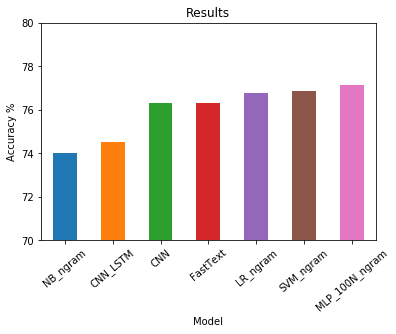

In [243]:
df_performances1.sort_values(by='Accuracy').plot.bar(x='Model',y="Accuracy",title="Results",legend=False)
plt.ylim(70, 80)
plt.ylabel("Accuracy %")
plt.xticks(rotation=40)
plt.show()

# Summary:
 Overall it seems that MLP has the highest accuracy among all the algorithms tested above.